# Desigualdades na Mobilidade Urbana no Brasil {.unnumbered}


## Glossário {-}

### 1. Viagens longas e qualidade de vida {-}

Introdução: Por que o tempo de deslocamento casa-trabalho é importante? 

### 2. Importação de Dados {-}

Visão geral das fontes de dados e do processo de importação.

### 3. Limpeza de Dados {-}

Tratamento dos dados para garantir a qualidade e a confiabilidade da análise.

### 4. Análise dos Dados {-}

Visualização e interpretação dos dados.

### 5. Conclusão {-}

Considerações finais e sugestão para futuras análises.

### 6. Referências {-}

## Viagens longas e qualidade de vida {-}

Estudos mostram que viagens longas para o trabalho estão associadas a maiores níveis de fadiga, estresse, má qualidade de saúde mental, tensão muscular e baixa satisfação com o trabalho [1]. Além disso, enfrentar longos engarrafamentos pode afetar negativamente a satisfação econômica [2]. Viagens longas também podem estar associadas a padrões comportamentais que, ao longo do tempo, contribuem para a obesidade e outros indicadores de má qualidade de saúde [3].

O objetivo desta análise é identificar quão desigual é o tempo médio de deslocamento casa-trabalho dos trabalhadores no Brasil. Para isso, utilizo os dados da PNS (Pesquisa Nacional de Saúde) de 2019 realizada pelo IBGE [5], o índice PNT (People Near Transit) do ITDP (Instituto de Políticas de Transporte e Desenvolvimento) [6] retirado da Mobilidados [7] e, para comparação, utilizo os dados do Eurostat (Gabinete de Estatísticas da União Europeia)."

## Importando os dados {-}

In [1]:
# Importação das bibliotecas   
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import squarify


Importando os dados da PNS 2019, Eurostat e do índice PNT.

In [2]:
pns_df_original = pd.read_csv("C:/Users/pdaniel/Learning/pns2019.csv")
euro_df = pd.read_excel("C:/Users/pdaniel/Learning/commute_time_europe.xlsx")
pnt_df = pd.read_excel("C:/Users/pdaniel/Learning/pnt_pessoas_proximas.xlsx", sheet_name = "PNT_RM", skiprows = 2)

## Limpeza dos dados {-}

### Tratando os dados da PNS 2019 {-}

O dataset da PNS é composta por códigos indicando as perguntas e respostas de cada cidadão entrevistado. O princiopal objetivo dessa seção é separar as informações úteis para a análise e converter os códigos de acordo com as informações fornecidas no dicionário da PNS 2019 [9]  

Alguns códigos utlizados na PNS:
* V0001 - Unidade da federação.
* M00402 - Quanto tempo em minutos o(a) Sr(a) gasta, normalmente, por dia, no deslocamento para o(s) seu(s) trabalho(s), considerando ida e volta. (somente pessoas empregadas) (Resposta em minutos) 
* M00401 - Quanto tempo em horas o(a) Sr(a) gasta(va), normalmente, por dia, no deslocamento para o(s) seu(s) trabalho(s), considerando ida e volta. (somente pessoas empregadas) (Respota em horas)
* V0026 - Tipo de situação censitária (Urbano ou Rural).
* VDF004 -Faixa de rendimento domiciliar per capita (exclusive o rendimento das pessoas cuja condição na unidade domiciliar era pensionista, empregado doméstico ou parente do empregado doméstico)* C009 > Cor ou raça


In [3]:
# Crio uma cópia do dataframe
pns_df = pns_df_original.copy()

# Criando um dicionário com os códigos da UF (V0001)
code_to_uf = {11:'Rondônia', 12:'Acre', 13:'Amazonas', 14:'Roraima', 15:'Pará', 16:'Amapá', 17:'Tocantins', 21:'Maranhão', 22:'Piauí', 23:'Ceará',
              24:'Rio Grande do Norte', 25:'Paraíba', 26:'Pernambuco', 27:'Alagoas', 28:'Sergipe', 29:'Bahia', 31:'Minas Gerais', 32:'Espírito Santo',
              33:'Rio de Janeiro', 35:'São Paulo', 41:'Paraná', 42:'Santa Catarina', 43:'Rio Grande do Sul', 50:'Mato Grosso do Sul', 51:'Mato Grosso',
              52:'Goiás', 53:'Distrito Federal'}

# Criando um dicionário para converter os códigos de localidade (V0026)
code_to_loc = {1:"Urbano", 2:"Rural"}

# Criando um dicionário para converter os códigos pela faixa de rendimento per capita (partes do salário mínimo)
rendimento_domiciliar = {1: "Até 0,25 salário mínimo", 2: "Mais de 0,25 até 0,5 salário mínimo", 3: "Mais de 0,5 até 1 salário mínimo",
                         4: "Mais de 1 até 2 salários mínimos", 5: "Mais de 2 até 3 salários mínimos", 6: "Mais de 3 até 5 salários mínimos",
                         7: "Mais de 5 salários mínimos"}

# Criando um dincionário para converter os códigos para a cor ou raça dos entrevistados.
code_to_race = {1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indígena', 9: 'Ignorado'}

# Renomeando as colunas
pns_df.rename(columns={"V0001": "uf", "M00402": "tempo_des_casa_trab_min", "M00401": "tempo_des_casa_trab_hr", "V0026": "localidade",
                       "VDF004": "renda_per_capta", "C009": "cor_raca"}, inplace=True)

# Convertendo os códigos dos UFs
pns_df["uf"] = pns_df["uf"].map(code_to_uf)

# Convertendo os códigos das localidadews
pns_df["localidade"] = pns_df["localidade"].map(code_to_loc)

# Convertendo os códigos de rendimento domiciliar per capta
pns_df["renda_per_capta"] = pns_df["renda_per_capta"].map(rendimento_domiciliar)

# Convertendo os códigos da cor ou raça do entrevistado.
pns_df["cor_raca"] = pns_df["cor_raca"].map(code_to_race)

# Filtrando os o dataframe para desconsiderar as entrevistas em que a cor/raça foi ignorada
pns_df = pns_df[pns_df['cor_raca'] != "Ignorado"]

# Filtrando o dataframe somente com as entrevistas de moradores da área urbana.
pns_df = pns_df[pns_df["localidade"] == "Urbano"]

# Transformo o tempo da coluna 'tempo_des_casa_trab_hr' de hora para minutos
pns_df["tempo_des_casa_trab_hr"] = pns_df["tempo_des_casa_trab_hr"]*60

# Crio uma outra coluna para somar o tempo das 'tempo_des_casa_trab_hr' e tempo_des_casa_trab_min' e ter o tempo de deslocamento total
pns_df["tempo_des_total_min"] = pns_df["tempo_des_casa_trab_hr"] + pns_df["tempo_des_casa_trab_min"]

# Filtro o dataframe somente com as colunas importantes
pns_df = pns_df[["uf", "tempo_des_casa_trab_min", "tempo_des_casa_trab_hr", "localidade", "renda_per_capta", "cor_raca", "tempo_des_total_min"]]

# Remove valores nulos
pns_df.dropna(inplace = True)

# Limito a visualização para no máximo 8 linhas e 8 colunas
pd.set_option('display.max_rows', 8)
pd.set_option('display.max_columns', 8)

display("Dataframe antes: ", pns_df_original, "Dataframe depois: ", pns_df)

'Dataframe antes: '

,V0001,V0024,UPA_PNS,V0006_PNS,...,VDM001,VDP001,VDR001,VDDATA
0,11,1110011,110000016,1,...,NaN,NaN,NaN,20210825
1,11,1110011,110000016,1,...,NaN,NaN,NaN,20210825
2,11,1110011,110000016,1,...,NaN,NaN,NaN,20210825
3,11,1110011,110000016,1,...,NaN,NaN,NaN,20210825
...,...,...,...,...,...,...,...,...,...
293722,53,5310220,530044434,14,...,NaN,NaN,NaN,20210825
293723,53,5310220,530044434,14,...,NaN,NaN,NaN,20210825
293724,53,5310220,530044434,14,...,NaN,NaN,NaN,20210825
293725,53,5310220,530044434,15,...,NaN,NaN,NaN,20210825


'Dataframe depois: '

,uf,tempo_des_casa_trab_min,tempo_des_casa_trab_hr,localidade,renda_per_capta,cor_raca,tempo_des_total_min
10,Rondônia,15.0,120.0,Urbano,"Mais de 0,5 até 1 salário mínimo",Preta,135.0
18,Rondônia,3.0,0.0,Urbano,"Mais de 0,25 até 0,5 salário mínimo",Preta,3.0
22,Rondônia,0.0,60.0,Urbano,Mais de 1 até 2 salários mínimos,Parda,60.0
29,Rondônia,20.0,0.0,Urbano,"Mais de 0,5 até 1 salário mínimo",Parda,20.0
...,...,...,...,...,...,...,...
293246,Distrito Federal,0.0,120.0,Urbano,Mais de 1 até 2 salários mínimos,Parda,120.0
293247,Distrito Federal,20.0,0.0,Urbano,Mais de 1 até 2 salários mínimos,Parda,20.0
293252,Distrito Federal,10.0,0.0,Urbano,"Mais de 0,5 até 1 salário mínimo",Parda,10.0
293255,Distrito Federal,0.0,120.0,Urbano,Mais de 1 até 2 salários mínimos,Parda,120.0


### Tratando os dados da Eurostat {-}

Aqui, estou utilizando um conjunto de dados previamente filtrado da Eurostat [10], que inclui o tempo médio de deslocamento casa-trabalho de trabalhadores em regiões urbanas da Europa.

Nesta seção, estou traduzindo os nomes dos países para o português, excluindo os itens "Euro area", "European Union" e "Turkey" do conjunto de dados, e multiplicando o tempo por dois (a Eurostat considera apenas o tempo de ida ao trabalho).

In [4]:
# Cria um novo dataframe filtrado
filtred_euro_df = euro_df[3:-1].copy() 

# Cria um dincionário para traduzir o nome dos países.
traducoes = {'Belgium': 'Bélgica', 'Bulgaria': 'Bulgária', 'Czechia': 'República Tcheca', 'Denmark': 'Dinamarca', 'Germany': 'Alemanha',
             'Estonia': 'Estônia', 'Ireland': 'Irlanda', 'Greece': 'Grécia', 'Spain': 'Espanha', 'France': 'França', 'Croatia': 'Croácia',
             'Italy': 'Itália', 'Cyprus': 'Chipre', 'Latvia': 'Letônia', 'Lithuania': 'Lituânia', 'Luxembourg': 'Luxemburgo', 'Hungary': 'Hungria',
             'Malta': 'Malta', 'Netherlands': 'Países Baixos', 'Austria': 'Áustria', 'Poland': 'Polônia', 'Portugal': 'Portugal', 'Romania': 'Romênia',
             'Slovenia': 'Eslovênia', 'Slovakia': 'Eslováquia', 'Finland': 'Finlândia', 'Sweden': 'Suécia', 'Iceland': 'Islândia', 'Norway': 'Noruega',
             'Switzerland': 'Suíça', 'United Kingdom': 'Reino Unido'}

# Traduzindo o nome dos países
filtred_euro_df['País'] = filtred_euro_df['País'].map(traducoes)

# Multiplico o tempo por dois para ter o tempo de ida e volta.
filtred_euro_df["Tempo (min)"] = filtred_euro_df["Tempo (min)"]*2 

display('Dataframe antes: ', euro_df, "Dataframe depois: ", filtred_euro_df)

'Dataframe antes: '

,País,Tempo (min)
0,European Union - 27 countries (from 2020),27
1,European Union - 28 countries (2013-2020),28
2,Euro area - 19 countries (2015-2022),27
3,Belgium,28
...,...,...
31,Norway,26
32,Switzerland,27
33,United Kingdom,30
34,Türkiye,:


'Dataframe depois: '

,País,Tempo (min)
3,Bélgica,56
4,Bulgária,56
5,República Tcheca,60
6,Dinamarca,52
...,...,...
30,Islândia,30
31,Noruega,52
32,Suíça,54
33,Reino Unido,60


### Tratando os dados do indicador PNT {-}

Aqui, separo as informações do dataset que serão úteis para a minha análise. Nesse caso, o indicador "PNT Geral", "UF" e "2019", que indica os valores de PNT no ano de 2019.
O dataset utilizado contém somente os estados mais populosos e o Distrtito Federal.

In [5]:
#Filtrando os resultados somente para o indicador "PNT GERAL"
pnt_df_filtrado = pnt_df[pnt_df["INDICADOR"] == "PNT_Geral"].copy()

# Filtrando os resultados somente para o ano de 2019 e use somente as colunas "UF" e "2019" do dataset.
pnt_df_filtrado = pnt_df_filtrado[["UF", 2019]]

# Organiza os valores em ordem decrescente
pnt_df_filtrado.sort_values(2019, ascending = False, inplace = True, ignore_index= True)

# Multiplico por 100 pois os valores estão expressos como porcentagem
pnt_df_filtrado[2019] = pnt_df_filtrado[2019]*100 


display("Dataframe antes: ", pnt_df, "Dataframe depois: ", pnt_df_filtrado)

'Dataframe antes: '

,CD_UF,UF,REGIAO METROPOLITANA,ID,...,2018,2019,2020,2021
0,15,PA,BELEM,1,...,0.05,0.09,0.09,0.09
1,15,PA,BELEM,2,...,0.03,0.06,0.06,0.06
2,15,PA,BELEM,3,...,0.05,0.08,0.08,0.08
3,15,PA,BELEM,4,...,0.08,0.13,0.13,0.13
...,...,...,...,...,...,...,...,...,...
59,35,SP,SÃO PAULO,4,...,0.14,0.15,0.15,0.15
60,35,SP,SÃO PAULO,5,...,0.30,0.31,0.31,0.31
61,35,SP,SÃO PAULO,6,...,0.09,0.09,0.09,0.09
62,35,SP,SÃO PAULO,7,...,0.11,0.12,0.12,0.12


'Dataframe depois: '

,UF,2019
0,RJ,19.0
1,PR,18.0
2,PE,14.0
3,SP,13.0
...,...,...
5,MG,8.0
6,CE,8.0
7,DF,6.0
8,BA,4.0


## Análise dos dados e visualizações {-}

### Brasil comparado a Europa {-}

Nessa seção, comparo o tempo de deslocamento médio do trabalhadores do Brasil com os trabalhadores ativos da Europa (de 15 até 74 anos somente de áreas urbanas).

In [6]:
# Determina o tempo médio de deslocamento do Brasil
num_entrevistas = pns_df["tempo_des_total_min"].count() # O método count() já desconsidera valores NaN
tempo_medio_brasil = pns_df["tempo_des_total_min"].sum()/num_entrevistas
print(f"Tempo de deslocamento médio do Brasil: {tempo_medio_brasil:.1f} minutos por dia ou {tempo_medio_brasil*5/60:.1f} horas por semana ", "\n")

# Cria um novo dataframe adicionando "Brasil" aos países da Uniao Europeia.
brasil_data = pd.DataFrame({'País': 'Brasil', "Tempo (min)": [round(tempo_medio_brasil)]})
brasil_euro_df = pd.concat([filtred_euro_df, brasil_data], ignore_index = True)
brasil_euro_df.sort_values('Tempo (min)', ascending = False, inplace = True, ignore_index = True) # Coloca em ordem decrescente por tempo
    
display("Novo dataframe", brasil_euro_df)

Tempo de deslocamento médio do Brasil: 59.1 minutos por dia ou 4.9 horas por semana  



'Novo dataframe'

,País,Tempo (min)
0,Letônia,68
1,Hungria,64
2,República Tcheca,60
3,Reino Unido,60
...,...,...
28,Estônia,46
29,Eslovênia,42
30,Chipre,38
31,Islândia,30


Aqui, realizo a visualização do dataframe.

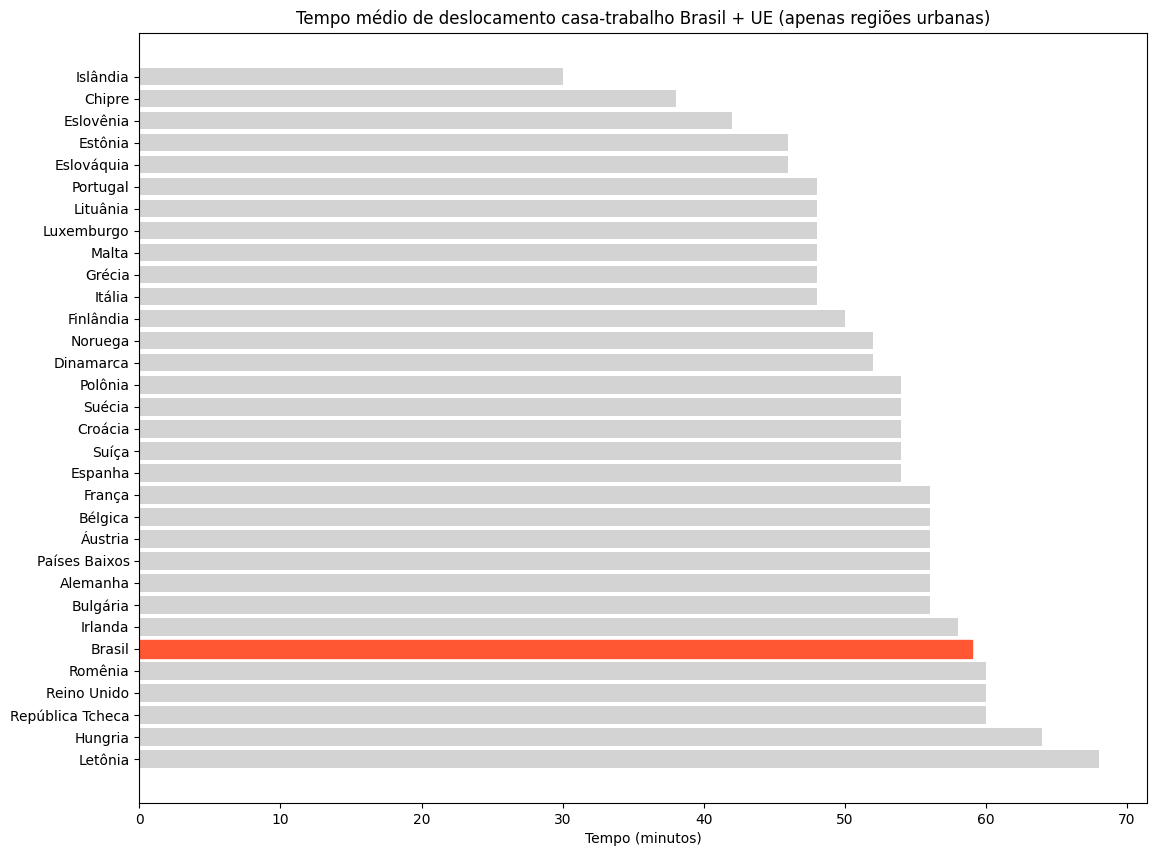

In [7]:
plt.figure(figsize=(13, 10))
barlist = plt.barh(brasil_euro_df["País"], brasil_euro_df["Tempo (min)"], color = "#D3D3D3") # Define o plot como barras horizontais 
plt.title('Tempo médio de deslocamento casa-trabalho Brasil + UE (apenas regiões urbanas)') # Define o título 
plt.xlabel('Tempo (minutos)') # Define o título do eixo "x" do gráfico
barlist[5].set_color('#FF5733') # Define a cor da barra do "Brasil"
plt.show()

Apesar de o Brasil ter um tempo médio de deslocamento apenas ligeiramente inferior aos países da UE, é importante enfatizar que alguns países da lista possuem condições um pouco mais igualitárias e homogêneas, como na Grécia e Chipre, onde, respectivamente, 75,8% e 75,5% da população estava sujeita às mesmas condições de um deslocamento de menos de 30 minutos na ida para o trabalho [4]. 
No caso do Brasil, um país de grande extensão territorial e com uma população muito grande e diversa, vale a pena investigar como diferentes grupos da população enfrentam essa questão.

### Acessibilidade aos meios de transporte no Brasil {-}


Para essa análise, utilizo o índice PNT, que é uma métrica que avalia o percentual da população de uma cidade ou região metropolitana que reside em um raio de até 1 km de estações de sistemas de transporte público de média e alta capacidade (BRT, metrô, trens, ...).
 
"A primeira pergunta a se fazer para entender do que se trata o PNT é: Existe uma estação de transporte de alta capacidade perto de onde as pessoas vivem?"

Aqui, basta realizar a visualização do dataframe.

C:\Users\pdaniel\AppData\Local\Temp\ipykernel_19436\3460320418.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(val) for val in plt.gca().get_yticks()]) # Formata o eixo para porcentagem


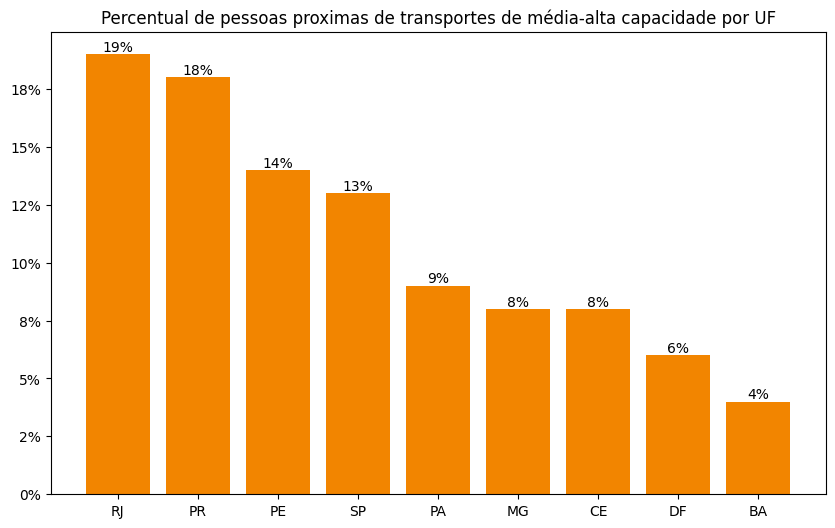

In [8]:
plt.figure(figsize=(10, 6))
bars = plt.bar(pnt_df_filtrado["UF"], pnt_df_filtrado[2019], color= "#F28500")
plt.title('Percentual de pessoas proximas de transportes de média-alta capacidade por UF')
plt.gca().set_yticklabels(['{:.0f}%'.format(val) for val in plt.gca().get_yticks()]) # Formata o eixo para porcentagem

# Cria o data label em cima de cada barra.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, '%d%%' % int(height),
             ha='center', va='bottom')

plt.show()

É possível concluir que apenas uma pequena parcela dos habitantes dos estados mais populosos possui fácil acesso a transportes de média-alta capacidade, o que impacta diretamente no tempo de deslocamento do cidadão. Ainda assim, esse impacto é muito mais significativo em grandes cidades e estados nos quais parte da população reside afastada dos principais centros de trabalho, como São Paulo e Rio de Janeiro.

### Tempo de deslocamento médio por UF apenas em regiões urbanas {-}

As análise aqui considerararão somente as regiões urbanas

Sabe-se cada UF do Brasil possui condições únicas de investimento e mobilidade urbana. No entanto, como essas condições refletem no tempo de deslocamento médio casa-trabalho dos trabalhadores?

In [9]:
# Crio um outro dataframe contendo somente as colunas de UF e tempo
tempo_des_uf= pns_df[["uf","tempo_des_total_min"]]

# Calculando o tempo médio por uf
temp_des_medio_uf = tempo_des_uf.groupby("uf", as_index= False)["tempo_des_total_min"].mean()

# Coloco em ordem decrescente por tempo de deslocamento
temp_des_medio_uf.sort_values('tempo_des_total_min', ascending = False, inplace = True, ignore_index = True)

# Calculando a variação percentual entre o melhor e o pior UF e o tempo médio de deslocamento do Brasil
var_per_maior = (temp_des_medio_uf['tempo_des_total_min'].max() - tempo_medio_brasil) * 100 / temp_des_medio_uf['tempo_des_total_min'].max()
var_per_menor = (temp_des_medio_uf['tempo_des_total_min'].min() - tempo_medio_brasil) * -100 / temp_des_medio_uf['tempo_des_total_min'].min()

display(temp_des_medio_uf)


,uf,tempo_des_total_min
0,Rio de Janeiro,87.106460
1,São Paulo,75.422006
2,Distrito Federal,71.347692
3,Bahia,69.165125
...,...,...
23,Tocantins,43.131898
24,Acre,42.732500
25,Rondônia,41.864286
26,Roraima,41.781777


Aqui já conseguimos notar uma grande variação no tempo médio de deslocamento por estado. Roraima tem um tempo 41.4% menor que a média nacional, enquanto Rio de Janeiro tem um tempo de 32.2% maior que a média nacional.


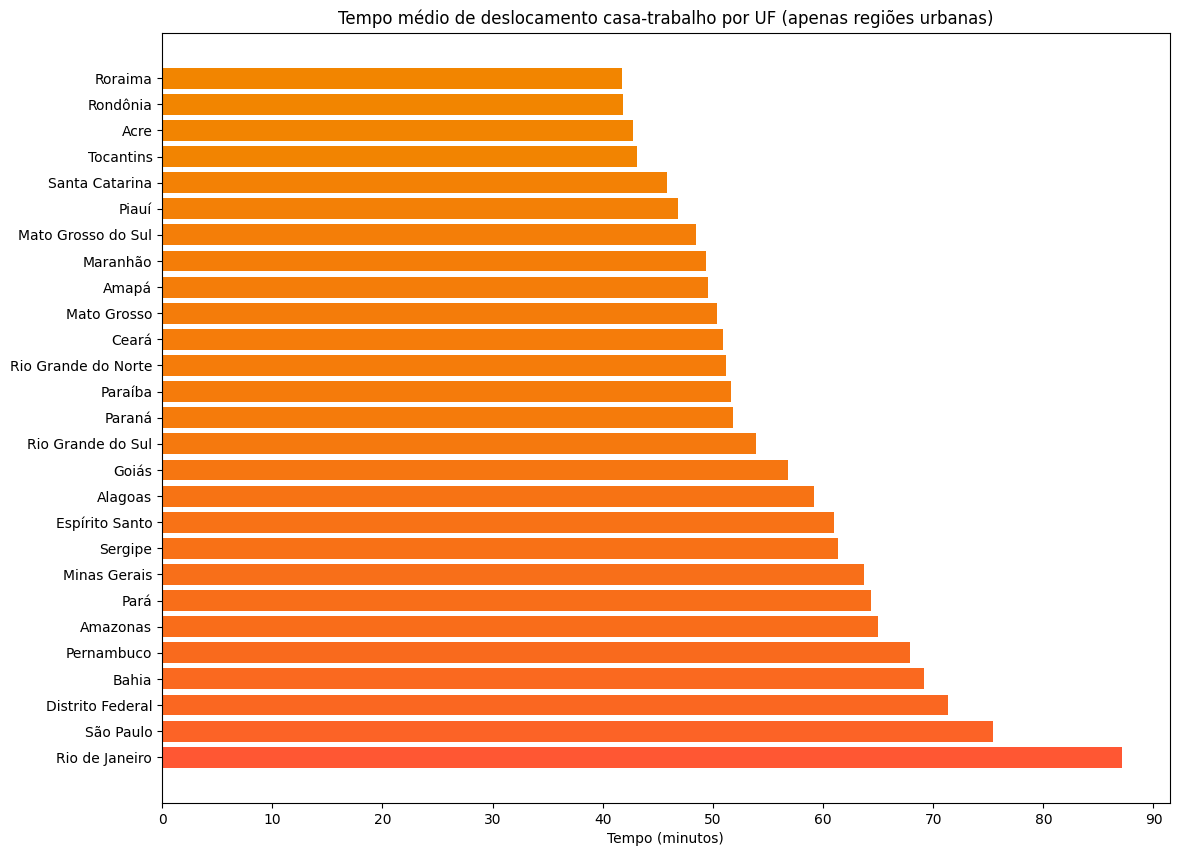

In [10]:
# Define o colormap (atribui uma cor para cada valor) como um gradiente de cores entre #F28500 e #FF5733 (Hex codes).
cmap = LinearSegmentedColormap.from_list('custom_gradient', ['#F28500', '#FF5733'])

# Normaliza os valores para criar o gradiente de cores
norm = mcolors.Normalize(vmin=min(temp_des_medio_uf["tempo_des_total_min"]), vmax=max(temp_des_medio_uf["tempo_des_total_min"]))

plt.figure(figsize=(13, 10))
plt.barh(temp_des_medio_uf["uf"], temp_des_medio_uf["tempo_des_total_min"], color = cmap(norm(temp_des_medio_uf["tempo_des_total_min"])))
plt.title('Tempo médio de deslocamento casa-trabalho por UF (apenas regiões urbanas)')
plt.xlabel('Tempo (minutos)')
plt.xticks(np.arange(0,100,10)) # Define a os valores exibidos no eixo x

print(f"""Aqui já conseguimos notar uma grande variação no tempo médio de deslocamento por estado. {temp_des_medio_uf['uf'].iloc[-1]} tem um tempo{var_per_menor: .1f}% menor que a média nacional, enquanto {temp_des_medio_uf['uf'].iloc[0]} tem um tempo de{var_per_maior: .1f}% maior que a média nacional.""")

plt.show()

Além da diferença entre UFs, é relevante examinar um outro aspecto dessa desigualdade: Como a desigualdade na locomoção se apresenta do ponto de vista econômico e racial?. 

É isso que será abordado nas próximas seções.

### Tempo dedeslocamento médio por renda familiar per capta {-}

Aqui eu filtro os dados para considerar somente os trabalhadores com renda familiar per capta acima de 0,5 salário mínimos para desconsiderar as situações de extrema pobreza.

In [11]:
# Crio um dataframe somente com as colunas de renda familiar per capta e tempo de deslocamento total em minutos
tempo_renda_df = pns_df[["renda_per_capta", "tempo_des_total_min"]]

# Calculando o tempo médio por renda
tempo_medio_renda_df = tempo_renda_df.groupby(tempo_renda_df["renda_per_capta"], as_index = False ).mean()

# Filtrando para eliminar trabalhadores que com renda familiar per capta abaixo de 0,5 salários mínimos
tempo_medio_renda_df_filtrado = tempo_medio_renda_df[2:]

display("Dataframe antes: ", tempo_renda_df, "Dataframe depois: ", tempo_medio_renda_df_filtrado)

'Dataframe antes: '

,renda_per_capta,tempo_des_total_min
10,"Mais de 0,5 até 1 salário mínimo",135.0
18,"Mais de 0,25 até 0,5 salário mínimo",3.0
22,Mais de 1 até 2 salários mínimos,60.0
29,"Mais de 0,5 até 1 salário mínimo",20.0
...,...,...
293246,Mais de 1 até 2 salários mínimos,120.0
293247,Mais de 1 até 2 salários mínimos,20.0
293252,"Mais de 0,5 até 1 salário mínimo",10.0
293255,Mais de 1 até 2 salários mínimos,120.0


'Dataframe depois: '

,renda_per_capta,tempo_des_total_min
2,"Mais de 0,5 até 1 salário mínimo",62.036997
3,Mais de 1 até 2 salários mínimos,59.916817
4,Mais de 2 até 3 salários mínimos,58.141786
5,Mais de 3 até 5 salários mínimos,55.165929
6,Mais de 5 salários mínimos,53.056036


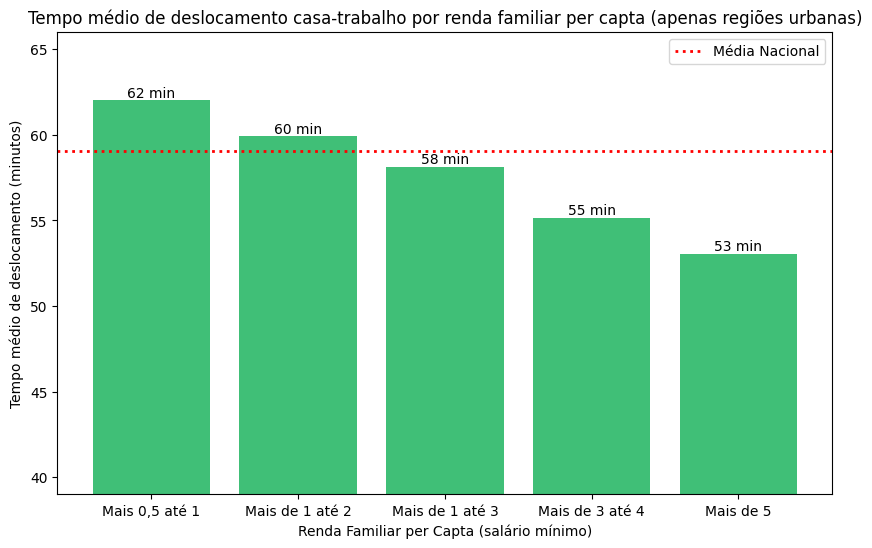

In [12]:
plt.figure(figsize=(10, 6))
bars = plt.bar(tempo_medio_renda_df_filtrado["renda_per_capta"], tempo_medio_renda_df_filtrado["tempo_des_total_min"], color="#40BF77")
plt.title('Tempo médio de deslocamento casa-trabalho por renda familiar per capta (apenas regiões urbanas)')
plt.xlabel('Renda Familiar per Capta (salário mínimo)')
plt.ylabel('Tempo médio de deslocamento (minutos)')
plt.axhline(y=tempo_medio_brasil,linewidth=2, color='red', linestyle = "dotted", label='Média Nacional') # Média nacional
plt.ylim(39, 66) # Modifico os limites do eixo y para melhorar a visibilidade das barras


# Renomeia as categorias
plt.xticks(tempo_medio_renda_df_filtrado["renda_per_capta"], ['Mais 0,5 até 1', 'Mais de 1 até 2', 'Mais de 1 até 3', 'Mais de 3 até 4', 'Mais de 5'])

# Cria o data label em cima de cada barra.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, str(round(height)) + " min",
             ha='center', va='bottom')

plt.legend()

plt.show()

E fica evidente que grupos sociais com rendas menores tendem a demorar mais tempo para chegar ao trabalho. Algumas das hipóteses que ajudam a explicar esse fenômeno, são elas: 

* Localização residencial/Opções de moradia -> Grupos de renda mais alta muitas vezes tem condições de morar ou se mudar para áreas mais próximas aos seus locas de trabalho.
* Meios de Transporte -> Uma renda maior facilita o acesso a mais variedades de meios de transporte mais rápidos e confortáveis, como táxis, carros particulares ou transporte por aplicativo, o que pode reduzir significativamente o tempo para chegar ao trabalho.
* Flexibilidade no horário de trabalho -> Pessoas com renda mais alta podem ter mais flexibilidade em seus horários de trabalho, o que pode ajuda-los a evitar os horários de pico no trânsito.

### Tempo médio de deslocamento por cor/raça. {-}

Aqui, analiso o tempo médio de deslocamento por cor/raça do trabalhador brasileiro.

In [13]:
# Cria um dataframe somente com a cor/raça e o tempo de deslocamento total em minutos.
tempo_des_raca_df = pns_df[['cor_raca', 'tempo_des_total_min']]

# Calculando o tempo médio por cor/raça
tempo_des_raca_medio_df = tempo_des_raca_df.groupby(tempo_des_raca_df["cor_raca"], as_index = False ).mean()

#tempo_des_raca_medio_df['cor_raca'] = tempo_des_raca_medio_df['cor_raca'].astype(str)
display(tempo_des_raca_medio_df)

,cor_raca,tempo_des_total_min
0,Amarela,62.801917
1,Branca,55.785523
2,Indígena,56.857741
3,Parda,58.991505
4,Preta,69.377244


Para a visualização dos dados, utilizo a biblioteca squarify junto com a matplotlib para fazer um treemap.

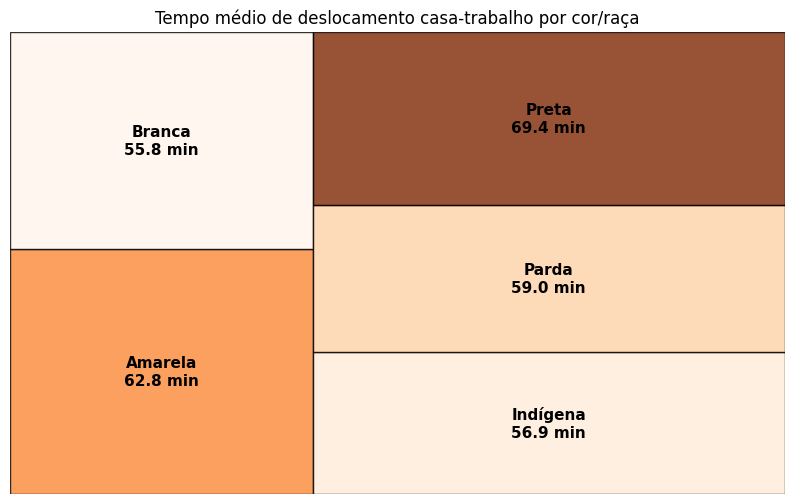

In [14]:
plt.figure(figsize=(10, 6))

# Cria labels para o treemap
labels = [f"{race}\n{time} min" for race, time in zip(tempo_des_raca_medio_df["cor_raca"], tempo_des_raca_medio_df["tempo_des_total_min"].round(1))]

# Define os parâmetros das labels.
text_kwargs = {'fontsize': 11, 'fontweight': 'bold', 'color': 'Black'}

# Normaliza os valores para criar o colormap (spectro de cores).
norm = plt.Normalize(tempo_des_raca_medio_df["tempo_des_total_min"].min(), tempo_des_raca_medio_df["tempo_des_total_min"].max())
colors = cm.Oranges(norm(tempo_des_raca_medio_df["tempo_des_total_min"])) # Utilizo o colormap "Oranges"

# Plota o treemap.
squarify.plot(sizes=tempo_des_raca_medio_df["tempo_des_total_min"], label=labels, ec = 'black', alpha=0.8, color=colors, text_kwargs = text_kwargs)

plt.title('Tempo médio de deslocamento casa-trabalho por cor/raça')
plt.axis('off') # Remove os eixos x/y do treemap
plt.show()

As diferenças étnicas são estruturais e muito complexas para a elaboração de hipóteses nesta análise. De qualquer forma, evidencia-se a existência de desigualdades significativas entre trabalhadores de diferentes cores/raças.

No caso mais extremo, os pretos gastam em média 69,4 minutos por dia ou 12 dias por ano no deslocamento para o trabalho, enquanto os brancos gastam em média 55,8 minutos por dia ou 9,6 dias por ano (desconsiderando feriados e finais de semana).

## Checagem do resultado {-}

O tempo médio de deslocamento ao trabalho encontrado nesta análise foi de aproximadamente 59,1 minutos por dia ou 4,9 horas por semana, enquanto a média publicada pela revista Valor Econômico [11], com base nos dados da PNS 2019, foi de 4,8 horas semanais.
Vale ressaltar que possivelmente certos parâmetros de filtragem (região urbana, rural, metropolitana, trabalhadores ativos ou inativos) podem ter sido diferentes, o que poderia explicar essa mínima diferença de 0,1 hora.


O valor encontrado na análise confere com o resultado divulgado pelo IBGE [12], considerando apenas áreas urbanas.

## Conclusão {-}

Embora o Brasil não apresente um tempo médio de deslocamento para o trabalho alarmente elevado quando comparado a padrões internacionais, observa-se uma significativa desigualdade, uma vez que diferentes grupos populacionais têm experiências bastante distintas.


#### Para análises mais profundas {-}

Para obter uma compreensão mais precisa da desigualdade no Brasil no tempo de deslocamento casa-trabalho em comparação com outros países nesse aspecto, poderíamos ampliar a análise calculando a **variância** e o **desvio padrão** para examinar a dispersão dos dados.

Além disso, uma análise da divisão modal (informação disponível na MobiliDados) permitiria obter informações sobre os meios de transporte mais utilizados pela população em cada cidade e UF, fornecendo dados valiosos para embasar decisões governamentais relacionadas a políticas de transporte e mobilidade urbana.

Academicamente, são necessários estudos mais aprofundados (como [1], que analisa a China, e [2] e [3], que analisam os EUA), buscando correlacionar o tempo gasto no deslocamento para o trabalho pelos brasileiros com indicadores de qualidade de vida e como isso afeta a satisfação e a produtividade dos trabalhadores.

## Referências {-}

1. Han L, Peng C, Xu Z. The Effect of Commuting Time on Quality of Life: Evidence from China. Int J Environ Res Public Health. 2022 Dec 29;20(1):573. doi: 10.3390/ijerph20010573. PMID: 36612893; PMCID: PMC9819363.
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9819363/#:~:text=Data%20from%20the%20US%20showed,strain%2C%20and%20poorer%20mental%20health.)

2. Gimenez-Nadal J.I., Molina J.A. Daily feelings of US workers and commuting time. J. Transp. Health. 2019;12:21–33. doi: 10.1016/j.jth.2018.11.001. 
(https://www.sciencedirect.com/science/article/abs/pii/S2214140518303086#preview-section-references)

3. Christian T.J. Trade-offs between commuting time and health-related activities. J Urban Health. 2012;89:746–757. doi: 10.1007/s11524-012-9678-6. 
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3462828/)

4. Main place of work and commuting time - statistics
(https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Main_place_of_work_and_commuting_time_-_statistics)

6. PNS - Pesquisa Nacional de Saúde
 (https://www.ibge.gov.br/estatisticas/sociais/saude/9160-pesquisa-nacional-de-saude.html)

7. ITDP lança o indicador PNT (People Near Transit)

 (https://itdpbrasil.org/pnt#

7. Mobilidados - Dados brutos e indicadores
 (https://mobilidados.org.br/database?category_slug=dados-brutos-e-indicadores))



8. Eurostat - Gabinete de Estatísticas da União Europeia (ou 'European Statistical Office').
 (https://ec.europa.eu/eurostat)

9. Documentação PNS 2019.
 (https://www.ibge.gov.br/estatisticas/downloads-estatisticas.html?caminho=PNS/2019/Microdados/Documentacao)

10. Persons in employment by commuting time, educational attainment level and degree of urbanisation.
 (https://ec.europa.eu/eurostat/databrowser/bookmark/138d1d25-ecb4-44a6-8d19-f1bb81410ebb?lang=en)l

11. Valor Econômico: Tempo de deslocamento ao trabalho no país é de 4,8h por semana, mas chega a 7,8h em SP.
 (https://valor.globo.com/brasil/noticia/2021/05/07/ibge-tempo-de-deslocamento-ao-trabalho-no-pais-e-de-48h-por-semana-mas-chega-a-78h-em-sp.ghtml)

12. IBGE - Educa: Deslocamento para o Trabalho ou Estudo.    
(https://educa.ibge.gov.br/professores/educa-atividades/21353-deslocamento-para-o-trabalho.html#:~:text=O%20tempo%20m%C3%A9dio%20de%20deslocamento,5%20horas%20em%20%C3%A1rea%20rural)
